In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

In [54]:
dataset, dataset_info = tfds.load('malaria', with_info=True,  split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'] , shuffle_files=True)
#split=['train[:80%]', 'train[80%:90%]', 'train[90%:]']

In [55]:

train_data=dataset[0]
test_data=dataset[1]
val_data=dataset[2]

print(len(train_data))
print(len(test_data))
print(len(val_data))


22046
2756
2756


In [56]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/Users/apple/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood s

In [57]:
def get_label(lbl):
    if lbl == 0:
        return "Infected"
    else:
        return "Healthy"
        

2024-06-04 09:17:12.295836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


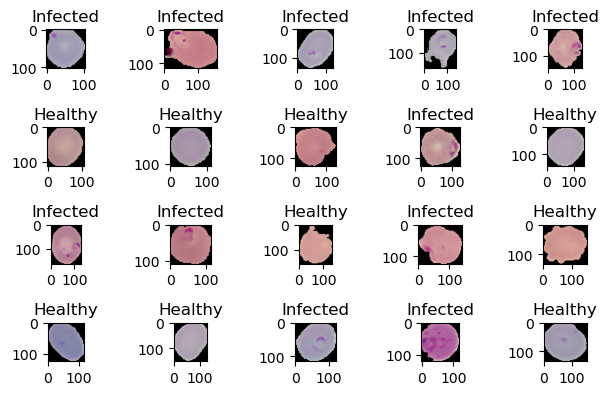

In [64]:
for i,sample in enumerate(train_data.take(20)):
    ax= plt.subplot(5, 5, i+1)
    plt.imshow(sample['image'])    
    plt.title(get_label(sample['label']) )
    plt.tight_layout()

In [92]:
im_size=224
batch_size=32

In [71]:
def resize_img(input):
    return tf.image.resize(input["image"],(im_size, im_size))/255., input["label"]

In [95]:
train_dataset = train_data.map(resize_img).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_data.map(resize_img).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.map(resize_img).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [76]:
for image, label in train_dataset.take(1):
    print(image.shape, label)

(224, 224, 3) tf.Tensor(1, shape=(), dtype=int64)


2024-06-04 09:54:58.614004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [100]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(im_size, im_size, 3)),
    
    tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D( strides=1, pool_size=2),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D( strides=2, pool_size=2),
    
    tf.keras.layers.Flatten( ),
    
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(1, activation="sigmoid"),
     
    
   
])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 221, 221, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 219, 219, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 219, 219, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 109, 109, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 190096)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │    19,009,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,012,297 (72.53 MB)

 Trainable params: 19,012,033 (72.53 MB)

 Non-trainable params: 264 (1.03 KB)

In [106]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["binary_accuracy"]
)

In [108]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    verbose=1
)

Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 555s 806ms/step - binary_accuracy: 0.9500 - loss: 0.1504 - val_binary_accuracy: 0.5758 - val_loss: 0.6355
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 568s 824ms/step - binary_accuracy: 0.9553 - loss: 0.1402 - val_binary_accuracy: 0.6749 - val_loss: 0.5522
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 577s 838ms/step - binary_accuracy: 0.9593 - loss: 0.1294 - val_binary_accuracy: 0.8748 - val_loss: 0.8918
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 554s 804ms/step - binary_accuracy: 0.9578 - loss: 0.1321 - val_binary_accuracy: 0.9478 - val_loss: 0.1712
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 378s 548ms/step - binary_accuracy: 0.9630 - loss: 0.1170 - val_binary_accuracy: 0.9336 - val_loss: 0.2147
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 438s 635ms/step - binary_accuracy: 0.9624 - loss: 0.1161 - val_binary_accuracy: 0.8770 - val_loss: 0.3295
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 408s 592ms/step - binary_accuracy: 0.9665 - loss: 0.1099 - val_binary_accurac

689/689 ━━━━━━━━━━━━━━━━━━━━ 495s 718ms/step - binary_accuracy: 0.9970 - loss: 0.0095 - val_binary_accuracy: 0.9115 - val_loss: 2.0601
Epoch 47/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 499s 724ms/step - binary_accuracy: 0.9882 - loss: 0.0416 - val_binary_accuracy: 0.9242 - val_loss: 1.0392
Epoch 48/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 538s 781ms/step - binary_accuracy: 0.9967 - loss: 0.0121 - val_binary_accuracy: 0.9213 - val_loss: 0.4779
Epoch 49/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 581s 844ms/step - binary_accuracy: 0.9959 - loss: 0.0117 - val_binary_accuracy: 0.9245 - val_loss: 0.6464
Epoch 50/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 569s 826ms/step - binary_accuracy: 0.9977 - loss: 0.0096 - val_binary_accuracy: 0.9267 - val_loss: 0.6580
Epoch 51/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 589s 855ms/step - binary_accuracy: 0.9974 - loss: 0.0075 - val_binary_accuracy: 0.9354 - val_loss: 0.7666
Epoch 52/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 602s 873ms/step - binary_accuracy: 0.9968 - loss: 0.0124 - val_binary_accuracy: 0.9

689/689 ━━━━━━━━━━━━━━━━━━━━ 552s 801ms/step - binary_accuracy: 0.9980 - loss: 0.0078 - val_binary_accuracy: 0.9292 - val_loss: 0.4681
Epoch 92/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 554s 804ms/step - binary_accuracy: 0.9992 - loss: 0.0026 - val_binary_accuracy: 0.9282 - val_loss: 0.7903
Epoch 93/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 558s 810ms/step - binary_accuracy: 0.9976 - loss: 0.0070 - val_binary_accuracy: 0.9278 - val_loss: 0.5518
Epoch 94/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 550s 798ms/step - binary_accuracy: 0.9986 - loss: 0.0034 - val_binary_accuracy: 0.9231 - val_loss: 0.5532
Epoch 95/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 556s 807ms/step - binary_accuracy: 0.9985 - loss: 0.0045 - val_binary_accuracy: 0.9122 - val_loss: 0.7715
Epoch 96/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 559s 811ms/step - binary_accuracy: 0.9979 - loss: 0.0068 - val_binary_accuracy: 0.9227 - val_loss: 0.7281
Epoch 97/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 549s 796ms/step - binary_accuracy: 0.9988 - loss: 0.0044 - val_binary_accuracy: 0.9

/var/folders/sh/w7k41c4d0818rt9wh61qvfhw0000gp/T/ipykernel_54639/903961205.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend("train_accuracy", "val_accuracy")
/var/folders/sh/w7k41c4d0818rt9wh61qvfhw0000gp/T/ipykernel_54639/903961205.py:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend("train_accuracy", "val_accuracy")


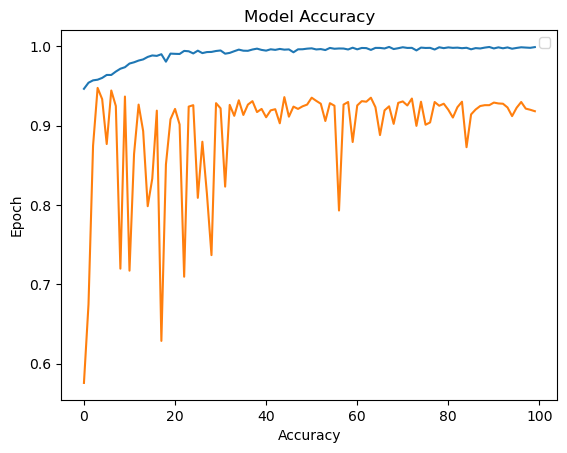

In [110]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend("train_accuracy", "val_accuracy")
plt.show()

In [111]:
model.evaluate(test_dataset)



87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - binary_accuracy: 0.9164 - loss: 0.7424


[0.7656476497650146, 0.9118287563323975]

In [113]:
def check_parasite(x):
    if x <0.5:
        return str("Infected")
    else:
        return str("Healthy")
    

In [114]:
def run_model(data):
    result = check_parasite(model.predict(data))
    return result



In [115]:
run_model(test_dataset.take(1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [118]:
model.save("model.keras")


In [119]:
model_loaded= tf.keras.models.load_model("model.keras")


/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [120]:
model_loaded.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 221, 221, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 219, 219, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 219, 219, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 109, 109, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 190096)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │    19,009,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,024,332 (145.05 MB)

 Trainable params: 19,012,033 (72.53 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 19,012,035 (72.53 MB)